# Libraries

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from pprint import pprint

from src.utils import (
    # Old utils
    print_h, eval_window, eval_person_majority_voting,

    # New utils
    set_seed, get_device, init_model, init_metrics, update_metrics, save_metrics_to_json,
    plot_k_fold_roc_curves_multiclass_v2, plot_k_fold_cm,
)
from src.models import HardMoE

/home/mitlab/miniconda3/envs/alxxtexxr_py312_torch22/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config

In [2]:
# Project config
seed = 69
set_seed(seed)
device = get_device()
print("Device:", device)

# Model config
expert_model_path_map = {
    # Default: RNN-InceptionTime
    'Ga': 'checkpoints/RNNInceptionTime_bidirectional_Ga_k10_w500_s500_e20_v20250520224322/fold_06.pth',
    'Ju': 'checkpoints/RNNInceptionTime_bidirectional_Ju_k10_w500_s500_w_anomaly_e5_v20250529001340/fold_06.pth',
    'Si': 'checkpoints/RNNInceptionTime_bidirectional_Si_k10_w500_s250_w_anomaly_e30_v20250529213629/fold_06.pth',

    # RNN
    # 'Ga': 'checkpoints/RNN_bidirectional_Ga_k10_w500_s500_fold_06_e20_v20250603125917/fold_06.pth',
    # 'Ju': 'checkpoints/RNN_bidirectional_Ju_k10_w500_s500_w_anomaly_fold_06_e5_v20250603130151/fold_06.pth',
    # 'Si': 'checkpoints/RNN_bidirectional_Si_k10_w500_s250_w_anomaly_fold_06_e30_v20250603130328/fold_06.pth',

    # InceptionTime
    # 'Ga': 'checkpoints/InceptionTime_Ga_k10_w500_s500_fold_06_e20_v20250603130439/fold_06.pth',
    # 'Ju': 'checkpoints/InceptionTime_Ju_k10_w500_s500_w_anomaly_fold_06_e5_v20250603130518/fold_06.pth',
    # 'Si': 'checkpoints/InceptionTime_Si_k10_w500_s250_w_anomaly_fold_06_e30_v20250603130612/fold_06.pth',
}

# Get model names and parameters
expert_names = [expert_model_dir.split('/')[-2].split('_'+study)[0] for study, expert_model_dir in expert_model_path_map.items()]
assert len(set(expert_names)) == 1, f"Expert model names are inconsistent: {expert_names}"
expert_name = expert_names[0]
if 'bidirectional' in expert_name:
    expert_name = expert_name.replace('_bidirectional', '')
    expert_bidirectional = True
else:
    expert_bidirectional = False
print("Expert model name:", expert_name)
print("Expert model bidirectional:", expert_bidirectional)

gate_model_path = 'checkpoints/RNNInceptionTimeGate_bidirectional_Ga_k10_w500_s500_Ju_k10_w500_s500_w_anomaly_Si_k10_w500_s250_w_anomaly_e20_v20250531134835/fold_06.pth' # Default: RNN-InceptionTime
# gate_model_path = 'checkpoints/MLPGate_l2_Ga_k10_w500_s500_Ju_k10_w500_s500_w_anomaly_Si_k10_w500_s250_w_anomaly_fold_06_e20_v20250602215409/fold_06.pth' # MLP
# gate_model_path = 'checkpoints/RNNGate_bidirectional_Ga_k10_w500_s500_Ju_k10_w500_s500_w_anomaly_Si_k10_w500_s250_w_anomaly_fold_06_e20_v20250603131259/fold_06.pth' # RNN
# gate_model_path = 'checkpoints/InceptionTimeGate_Ga_k10_w500_s500_Ju_k10_w500_s500_w_anomaly_Si_k10_w500_s250_w_anomaly_fold_06_e20_v20250603131830/fold_06.pth' # InceptionTime

gate_layers = [500, 500]
gate_ps = [0.1, 0.2]

# Data config
fold_i_dir_map = {
    'Ga': f'data/preprocessed/Ga_k10_w500_s500_v20250501004633/fold_06',
    'Ju': f'data/preprocessed/Ju_k10_w500_s500_w_anomaly_v20250501004735/fold_06',
    'Si': f'data/preprocessed/Si_k10_w500_s250_w_anomaly_v20250501004847/fold_06',
}

# Get fold number
i_folds_data = [int(fold_i_dir.split('fold_')[-1]) for fold_i_dir in fold_i_dir_map.values()]
i_folds_checkpoints = [int(expert_model_path.split('fold_')[-1].replace('.pth', '')) for expert_model_path in expert_model_path_map.values()]
i_folds = i_folds_data + i_folds_checkpoints
assert len(set(i_folds)) == 1, f"Fold numbers are inconsistent: {({'data': i_folds_data, 'checkpoints': i_folds_checkpoints})}"
i_fold = i_folds[0]
print("Fold number:", i_fold)

# Evaluation config
k_fold = 10
batch_size = 8
n_feat = 16
n_class = 4
window_size = 500
max_vgrf_data_len = 25_000

gate_name_tag = gate_model_path.rsplit('/')[-2].split('_Ga')[0]
gate_name = gate_name_tag.split('Gate')[0]
gate_bidirectional = 'bidirectional' in gate_name_tag
print("Gate model name tag:", gate_name_tag)
print("Gate model name:", gate_name)
print("Gate model bidirectional:", gate_bidirectional)

moe_name_tag = f'{expert_name}MoE{'_bidirectional' if expert_bidirectional else ''}{f'_{gate_name_tag}' if gate_name != expert_name else ''}'
print("MoE model name tag:", moe_name_tag)

eval_dir = 'evaluations/' + moe_name_tag + gate_model_path.rsplit(gate_name_tag)[-1].split('_v')[0]
out_viz_dir = eval_dir + '/out_viz'

print("Evaluation directory:", eval_dir)
print("Evaluation output visualization save directory:", out_viz_dir)

2025-06-05 15:10:03.551057: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-05 15:10:03.571503: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-05 15:10:03.577773: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-05 15:10:03.593227: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-05 15:10:04.570074: W tensorflow/compiler/tf2

Random seed: 69
Device: cuda
Expert model name: RNNInceptionTime
Expert model bidirectional: True
Fold number: 6
Gate model name tag: RNNInceptionTimeGate_bidirectional
Gate model name: RNNInceptionTime
Gate model bidirectional: True
MoE model name tag: RNNInceptionTimeMoE_bidirectional
Evaluation directory: evaluations/RNNInceptionTimeMoE_bidirectional_Ga_k10_w500_s500_Ju_k10_w500_s500_w_anomaly_Si_k10_w500_s250_w_anomaly_e20
Evaluation output visualization save directory: evaluations/RNNInceptionTimeMoE_bidirectional_Ga_k10_w500_s500_Ju_k10_w500_s500_w_anomaly_Si_k10_w500_s250_w_anomaly_e20/out_viz


In [3]:
study_label_map = {
    'Ga': 0,
    'Ju': 1,
    'Si': 2,
}

print_h(f"FOLD {i_fold}", 128)

expert_model_map = {
    'Ga': init_model(expert_name, device, c_in=n_feat, c_out=n_class, seq_len=window_size, bidirectional=expert_bidirectional),
    'Ju': init_model(expert_name, device, c_in=n_feat, c_out=n_class, seq_len=window_size, bidirectional=expert_bidirectional),
    'Si': init_model(expert_name, device, c_in=n_feat, c_out=n_class, seq_len=window_size, bidirectional=expert_bidirectional),
}

X_train_window_GaJuSi = torch.empty(0, window_size, n_feat).float()
y_train_window_GaJuSi = torch.empty(0).long()
study_labels_train_window_GaJuSi = torch.empty(0).long()

X_val_window_GaJuSi = torch.empty(0, window_size, n_feat).float()
y_val_window_GaJuSi = torch.empty(0).long()
study_labels_val_window_GaJuSi = torch.empty(0).long()

X_test_window_GaJuSi = torch.empty(0, window_size, n_feat).float()
y_test_window_GaJuSi = torch.empty(0).long()
study_labels_test_window_GaJuSi = torch.empty(0).long()

X_val_person_GaJuSi = torch.empty(0, max_vgrf_data_len, n_feat).float()
y_val_person_GaJuSi = torch.empty(0).long()
# study_labels_val_person_GaJuSi = torch.empty(0).long()

X_test_person_GaJuSi = torch.empty(0, max_vgrf_data_len, n_feat).float()
y_test_person_GaJuSi = torch.empty(0).long()
# study_labels_test_person_GaJuSi = torch.empty(0).long()

for study, fold_i_dir in fold_i_dir_map.items():
    # ================================================================================================
    # DATA
    # ================================================================================================
    X_train_window = torch.tensor(np.load(os.path.join(fold_i_dir, f'X_train_window.npy'))).float()
    y_train_window = torch.tensor(np.load(os.path.join(fold_i_dir, f'y_train_window.npy'))).long()
    study_labels_train_window = torch.tensor([study_label_map[study]] * len(y_train_window)).long()
    X_train_window_GaJuSi = torch.cat((X_train_window_GaJuSi, X_train_window), dim=0)
    y_train_window_GaJuSi = torch.cat((y_train_window_GaJuSi, y_train_window), dim=0)
    study_labels_train_window_GaJuSi = torch.cat((study_labels_train_window_GaJuSi, study_labels_train_window), dim=0)

    X_val_window = torch.tensor(np.load(os.path.join(fold_i_dir, f'X_val_window.npy'))).float()
    y_val_window = torch.tensor(np.load(os.path.join(fold_i_dir, f'y_val_window.npy'))).long()
    study_labels_val_window = torch.tensor([study_label_map[study]] * len(y_val_window)).long()
    X_val_window_GaJuSi = torch.cat((X_val_window_GaJuSi, X_val_window), dim=0)
    y_val_window_GaJuSi = torch.cat((y_val_window_GaJuSi, y_val_window), dim=0)
    study_labels_val_window_GaJuSi = torch.cat((study_labels_val_window_GaJuSi, study_labels_val_window), dim=0)

    X_test_window = torch.tensor(np.load(os.path.join(fold_i_dir, f'X_test_window.npy'))).float()
    y_test_window = torch.tensor(np.load(os.path.join(fold_i_dir, f'y_test_window.npy'))).long()
    study_labels_test_window = torch.tensor([study_label_map[study]] * len(y_test_window)).long()
    X_test_window_GaJuSi = torch.cat((X_test_window_GaJuSi, X_test_window), dim=0)
    y_test_window_GaJuSi = torch.cat((y_test_window_GaJuSi, y_test_window), dim=0)
    study_labels_test_window_GaJuSi = torch.cat((study_labels_test_window_GaJuSi, study_labels_test_window), dim=0)

    X_val_person = torch.tensor(np.load(os.path.join(fold_i_dir, f'X_val_person.npy'))).float()
    y_val_person = torch.tensor(np.load(os.path.join(fold_i_dir, f'y_val_person.npy'))).long()
    X_val_person_GaJuSi = torch.cat((X_val_person_GaJuSi, X_val_person), dim=0)
    y_val_person_GaJuSi = torch.cat((y_val_person_GaJuSi, y_val_person), dim=0)

    X_test_person = torch.tensor(np.load(os.path.join(fold_i_dir, f'X_test_person.npy'))).float()
    y_test_person = torch.tensor(np.load(os.path.join(fold_i_dir, f'y_test_person.npy'))).long()
    X_test_person_GaJuSi = torch.cat((X_test_person_GaJuSi, X_test_person), dim=0)
    y_test_person_GaJuSi = torch.cat((y_test_person_GaJuSi, y_test_person), dim=0)

    train_window_dataset = TensorDataset(X_train_window, y_train_window)
    val_window_dataset = TensorDataset(X_val_window, y_val_window)
    test_window_dataset = TensorDataset(X_test_window, y_test_window)
    
    val_person_dataset = TensorDataset(X_val_person, y_val_person)
    test_person_dataset = TensorDataset(X_test_person, y_test_person)

    train_dataloader = DataLoader(train_window_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_window_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_window_dataset, batch_size=batch_size, shuffle=False)
    
    # ================================================================================================
    # EXPERT MODEL
    # ================================================================================================
    expert_model = expert_model_map[study]
    expert_model.load_state_dict(torch.load(expert_model_path_map[study], map_location=device))

# ================================================================================================
# GATE MODEL
# ================================================================================================
gate_model = init_model(gate_name, device, c_in=n_feat, c_out=len(study_label_map.keys()), seq_len=window_size, bidirectional=gate_bidirectional, layers=gate_layers, ps=gate_ps)
gate_model.load_state_dict(torch.load(gate_model_path, map_location=device))

# ================================================================================================
# MoE MODEL
# ================================================================================================
moe_model = HardMoE(experts=expert_model_map.values(), gate=gate_model).to(device)

                                                             FOLD 6                                                             


# Output Visualization

In [4]:
def sample_dataset(X, y, study_labels, study, cls):
    study_ = study
    study = study_label_map[study_]
    
    mask = (y == cls) & (study_labels == study)
    X_cls = X[mask]
    y_cls = y[mask]
    study_labels_cls = study_labels[mask]

    if X_cls.shape[0] > 0:
        idx_sample = torch.randint(0, X_cls.shape[0], (1,)).item()
        X_sample = X_cls[idx_sample].unsqueeze(0)
        y_sample = y_cls[idx_sample].item()
        study_labels_sample = study_labels_cls[idx_sample].item()

        assert cls == y_sample
        assert study == study_labels_sample
        
        return X_sample, cls, study_
    return None, cls, study_

studies = study_label_map.keys()
classes = list(range(n_class))
study_cls_list = [study + '_' + str(cls) for cls in classes for study in studies]

X_sample_map = {study_cls: sample_dataset(X_test_window_GaJuSi, y_test_window_GaJuSi, study_labels_test_window_GaJuSi, study=study_cls.split('_')[0], cls=int(study_cls.split('_')[-1]))[0] for study_cls in study_cls_list}

# DEBUG: Sanity check
for k, v in X_sample_map.items():
    print(k, "->", v.shape if v != None else None)

model_map = {
    'gate': gate_model,
    **expert_model_map,
}
output_map = {study_cls: {} for study_cls in X_sample_map.keys()}

Ga_0 -> torch.Size([1, 500, 16])
Ju_0 -> torch.Size([1, 500, 16])
Si_0 -> torch.Size([1, 500, 16])
Ga_1 -> torch.Size([1, 500, 16])
Ju_1 -> torch.Size([1, 500, 16])
Si_1 -> torch.Size([1, 500, 16])
Ga_2 -> torch.Size([1, 500, 16])
Ju_2 -> torch.Size([1, 500, 16])
Si_2 -> torch.Size([1, 500, 16])
Ga_3 -> torch.Size([1, 500, 16])
Ju_3 -> torch.Size([1, 500, 16])
Si_3 -> None


In [5]:
for study_cls, X_sample in X_sample_map.items():
    if X_sample is None:
        continue

    print_h(study_cls)

    for model_type in model_map.keys():
        print_h(("EXPERT-" + model_type if len(model_type) == 2 else model_type.upper()) + " MODEL", 96)

        # Register hooks
        intermediate_outputs = {}

        def get_output_hook(name):
            def hook(module, input, output):
                intermediate_outputs[name] = output.detach().cpu().numpy()
            return hook

        model_map[model_type].rnn_dropout.register_forward_hook(get_output_hook('rnn_output'))
        model_map[model_type].gap.register_forward_hook(get_output_hook('gap'))
        model_map[model_type].concat.register_forward_hook(get_output_hook('concat'))

        # Forward pass
        model_map[model_type].eval()
        with torch.no_grad():
            model_map[model_type](X_sample.permute(0, 2, 1).to(device))

        print("RNN output:", intermediate_outputs['rnn_output'].shape)
        print("InceptionTime output:", intermediate_outputs['gap'].shape)
        print("Concatenated RNN-InceptionTime output:", intermediate_outputs['concat'].shape)

        # Store the `concat` output
        output_map[study_cls][model_type] = intermediate_outputs['concat']

        # TODO: Remove the hooks

        print()

                                                              Ga_0                                                              
                                           GATE MODEL                                           
RNN output: (1, 256)
InceptionTime output: (1, 128)
Concatenated RNN-InceptionTime output: (1, 384)

                                        EXPERT-Ga MODEL                                         
RNN output: (1, 256)
InceptionTime output: (1, 128)
Concatenated RNN-InceptionTime output: (1, 384)

                                        EXPERT-Ju MODEL                                         
RNN output: (1, 256)
InceptionTime output: (1, 128)
Concatenated RNN-InceptionTime output: (1, 384)

                                        EXPERT-Si MODEL                                         
RNN output: (1, 256)
InceptionTime output: (1, 128)
Concatenated RNN-InceptionTime output: (1, 384)

                                                              Ju_0             

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def plot_output_heatmap(output_map, name, save_dir=None, plot=False):
    # Create subplots
    fig, axes = plt.subplots(len(output_map), 1, figsize=(16, 6))

    for i, item in enumerate(output_map.items()):
        model_type, output = item
        output_norm = (output - output.min()) / (output.max() - output.min() + 1e-8)
        sns.heatmap(output_norm, ax=axes[i], yticklabels=False, cmap='viridis', cbar=False)

        # Add left-side "title" using ylabel
        title = "Expert - " + model_type if len(model_type) == 2 else model_type.capitalize()
        axes[i].set_ylabel(title, labelpad=11, va='center')

        # Add border around the entire heatmap axes
        for spine in axes[i].spines.values():
            spine.set_visible(True)
            spine.set_linewidth(1)
            spine.set_edgecolor('black')

    # Create a single colorbar axis on the right side
    norm = Normalize(vmin=0, vmax=1)
    sm = ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    cbar_ax = fig.add_axes([0.92, 0.085, 0.01, 0.89]) # [left, bottom, width, height] in figure coords
    cbar = fig.colorbar(sm, cax=cbar_ax)

    # Remove the black border from the colorbar
    cbar.outline.set_visible(False)

    plt.tight_layout(rect=[0, 0, 0.91, 1]) # Leave space on the right for colorbar

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, name + '.png')
        plt.savefig(save_path)

    if plot:
        plt.show()

    if save_dir:
        print("Saved to:", save_path)

                                                              Ga_0                                                              


/tmp/ipykernel_200723/3677284538.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 1]) # Leave space on the right for colorbar


Saved to: evaluations/RNNInceptionTimeMoE_bidirectional_Ga_k10_w500_s500_Ju_k10_w500_s500_w_anomaly_Si_k10_w500_s250_w_anomaly_e20/out_viz/Ga_0.png

                                                              Ju_0                                                              


/tmp/ipykernel_200723/3677284538.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 1]) # Leave space on the right for colorbar


Saved to: evaluations/RNNInceptionTimeMoE_bidirectional_Ga_k10_w500_s500_Ju_k10_w500_s500_w_anomaly_Si_k10_w500_s250_w_anomaly_e20/out_viz/Ju_0.png

                                                              Si_0                                                              


/tmp/ipykernel_200723/3677284538.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 1]) # Leave space on the right for colorbar


Saved to: evaluations/RNNInceptionTimeMoE_bidirectional_Ga_k10_w500_s500_Ju_k10_w500_s500_w_anomaly_Si_k10_w500_s250_w_anomaly_e20/out_viz/Si_0.png

                                                              Ga_1                                                              


/tmp/ipykernel_200723/3677284538.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 1]) # Leave space on the right for colorbar


Saved to: evaluations/RNNInceptionTimeMoE_bidirectional_Ga_k10_w500_s500_Ju_k10_w500_s500_w_anomaly_Si_k10_w500_s250_w_anomaly_e20/out_viz/Ga_1.png

                                                              Ju_1                                                              


/tmp/ipykernel_200723/3677284538.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 1]) # Leave space on the right for colorbar


Saved to: evaluations/RNNInceptionTimeMoE_bidirectional_Ga_k10_w500_s500_Ju_k10_w500_s500_w_anomaly_Si_k10_w500_s250_w_anomaly_e20/out_viz/Ju_1.png

                                                              Si_1                                                              


/tmp/ipykernel_200723/3677284538.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 1]) # Leave space on the right for colorbar


Saved to: evaluations/RNNInceptionTimeMoE_bidirectional_Ga_k10_w500_s500_Ju_k10_w500_s500_w_anomaly_Si_k10_w500_s250_w_anomaly_e20/out_viz/Si_1.png

                                                              Ga_2                                                              


/tmp/ipykernel_200723/3677284538.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 1]) # Leave space on the right for colorbar


Saved to: evaluations/RNNInceptionTimeMoE_bidirectional_Ga_k10_w500_s500_Ju_k10_w500_s500_w_anomaly_Si_k10_w500_s250_w_anomaly_e20/out_viz/Ga_2.png

                                                              Ju_2                                                              


/tmp/ipykernel_200723/3677284538.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 1]) # Leave space on the right for colorbar


Saved to: evaluations/RNNInceptionTimeMoE_bidirectional_Ga_k10_w500_s500_Ju_k10_w500_s500_w_anomaly_Si_k10_w500_s250_w_anomaly_e20/out_viz/Ju_2.png

                                                              Si_2                                                              


/tmp/ipykernel_200723/3677284538.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 1]) # Leave space on the right for colorbar


Saved to: evaluations/RNNInceptionTimeMoE_bidirectional_Ga_k10_w500_s500_Ju_k10_w500_s500_w_anomaly_Si_k10_w500_s250_w_anomaly_e20/out_viz/Si_2.png

                                                              Ga_3                                                              


/tmp/ipykernel_200723/3677284538.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 1]) # Leave space on the right for colorbar


Saved to: evaluations/RNNInceptionTimeMoE_bidirectional_Ga_k10_w500_s500_Ju_k10_w500_s500_w_anomaly_Si_k10_w500_s250_w_anomaly_e20/out_viz/Ga_3.png

                                                              Ju_3                                                              


/tmp/ipykernel_200723/3677284538.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 1]) # Leave space on the right for colorbar


Saved to: evaluations/RNNInceptionTimeMoE_bidirectional_Ga_k10_w500_s500_Ju_k10_w500_s500_w_anomaly_Si_k10_w500_s250_w_anomaly_e20/out_viz/Ju_3.png



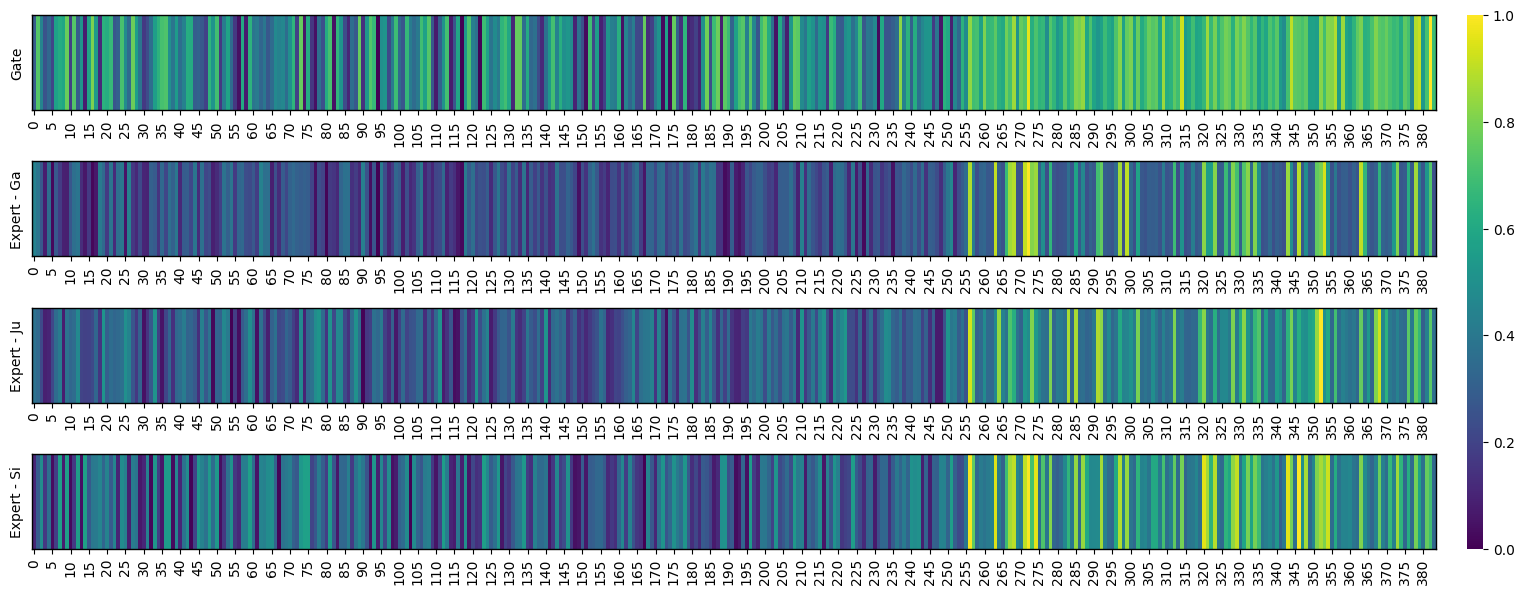

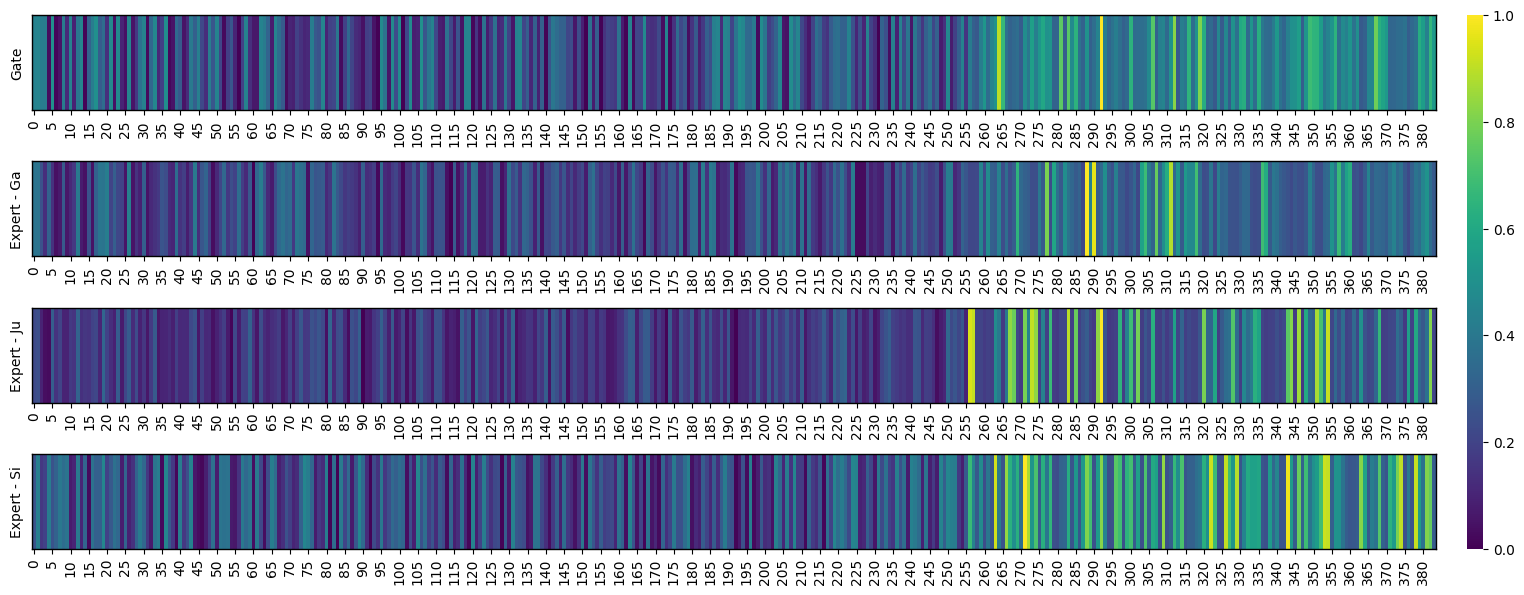

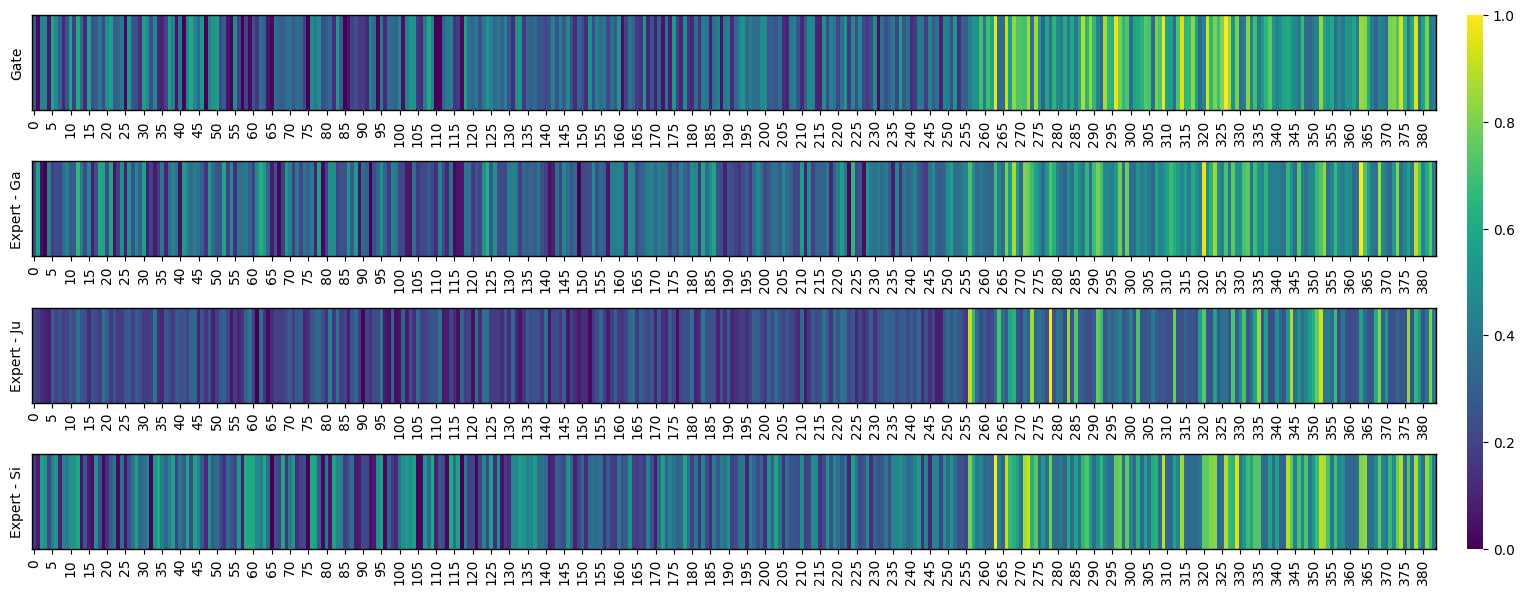

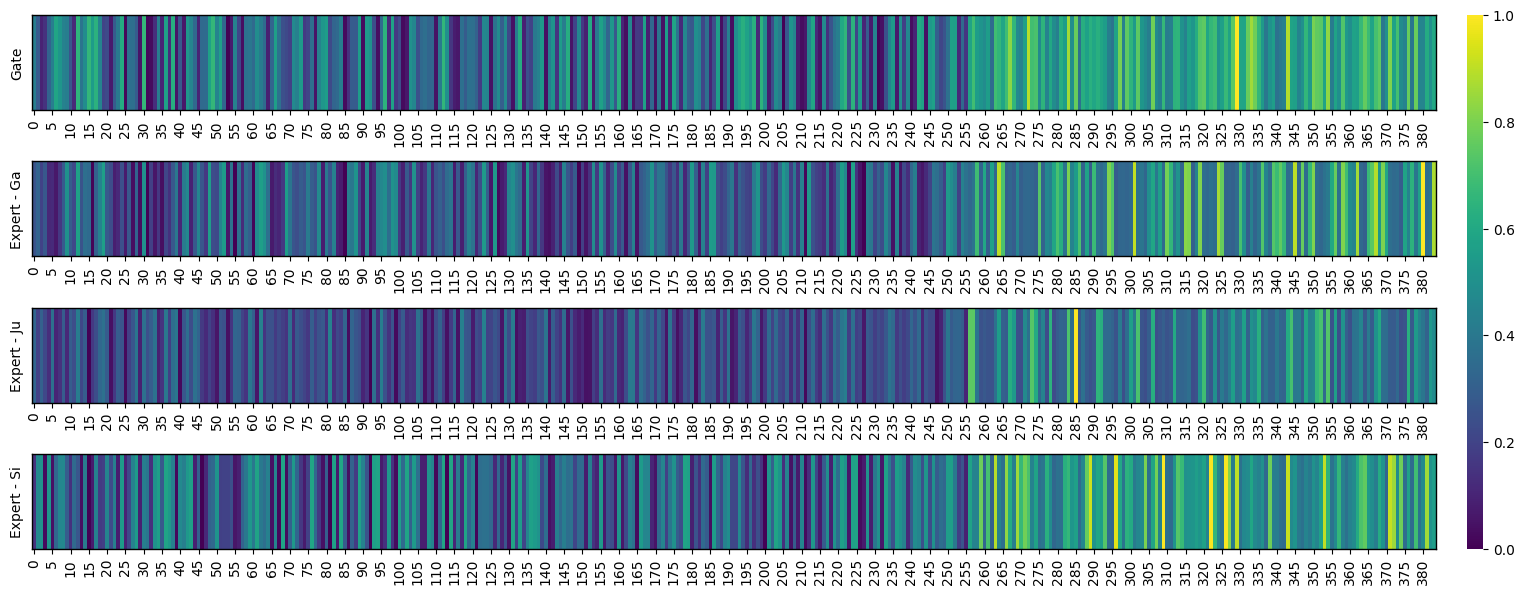

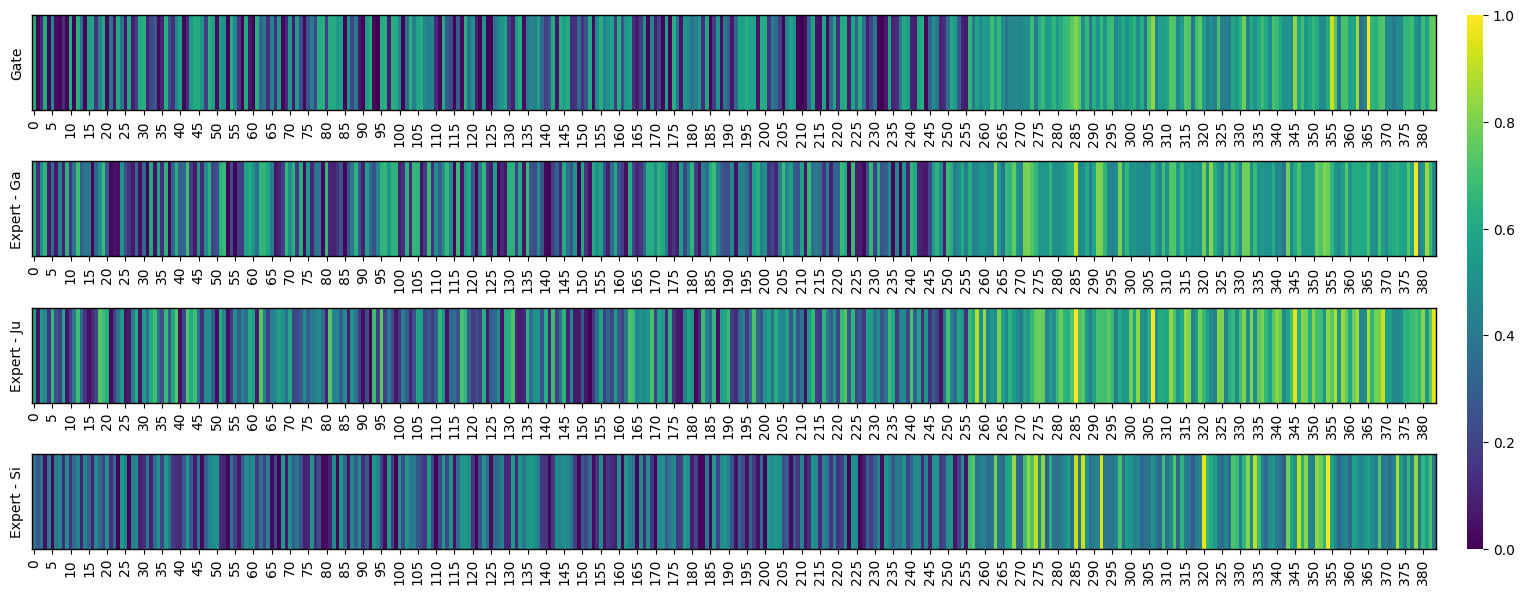

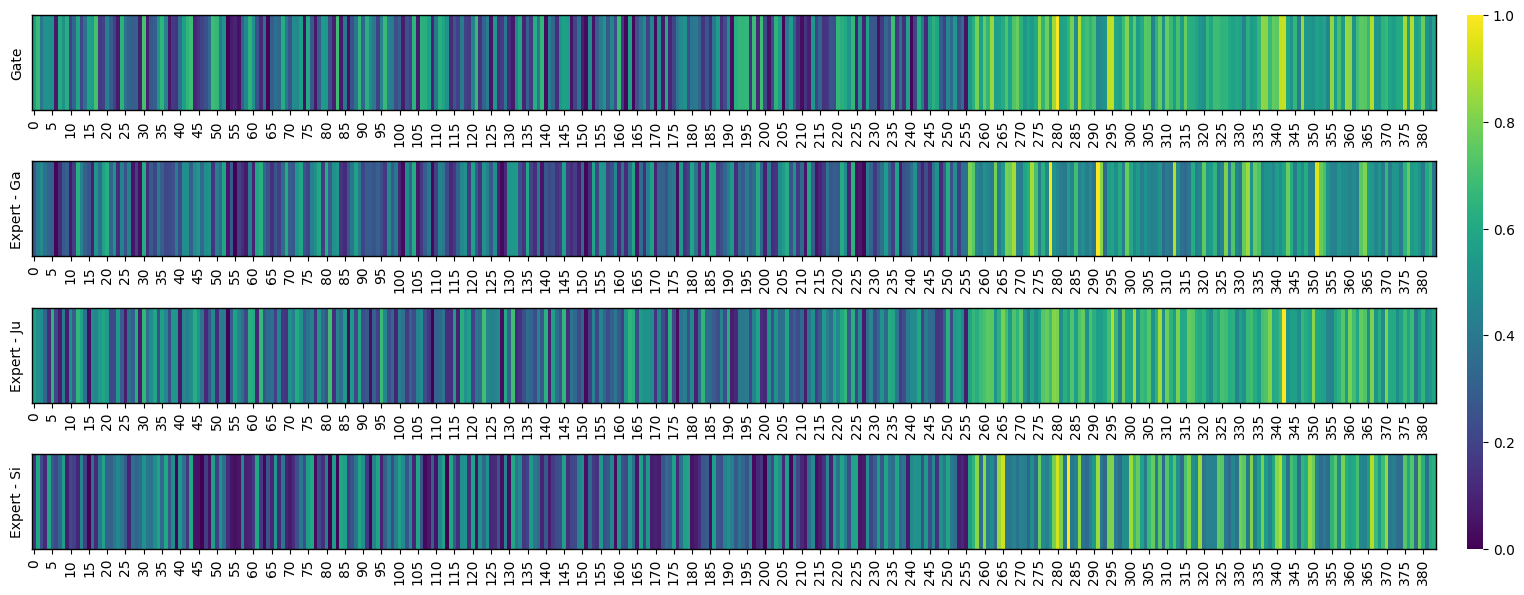

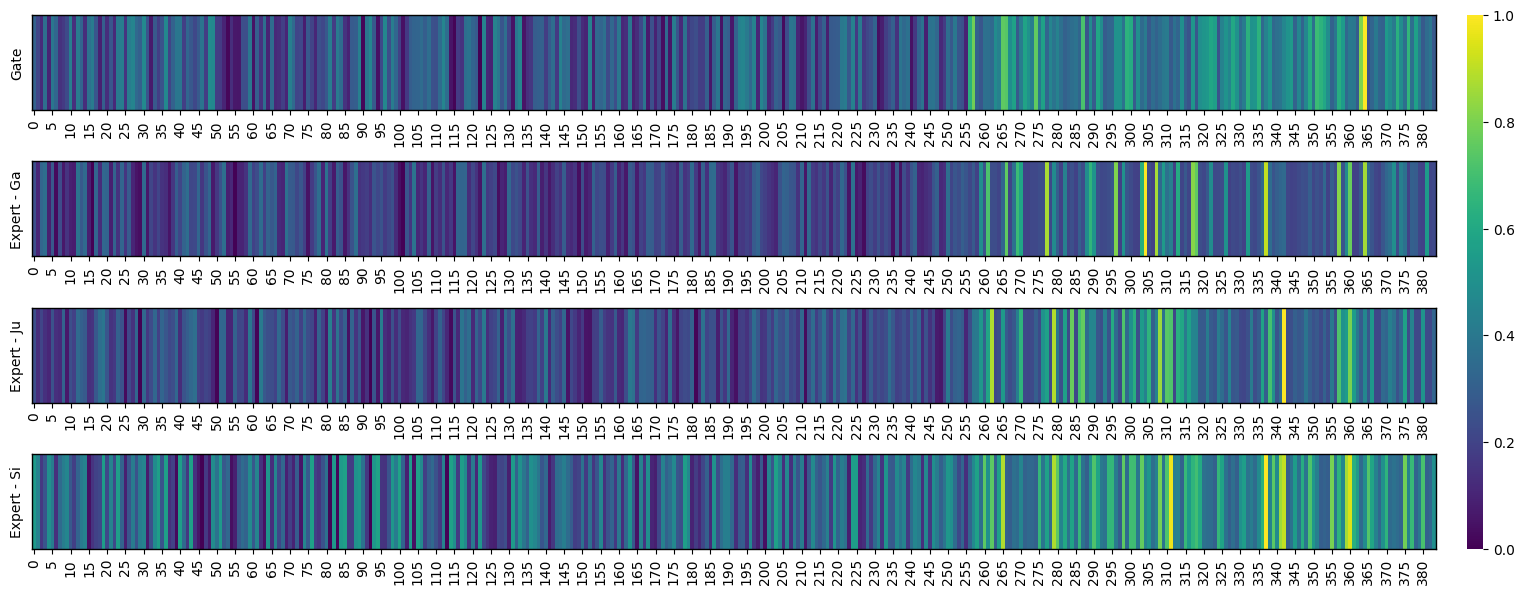

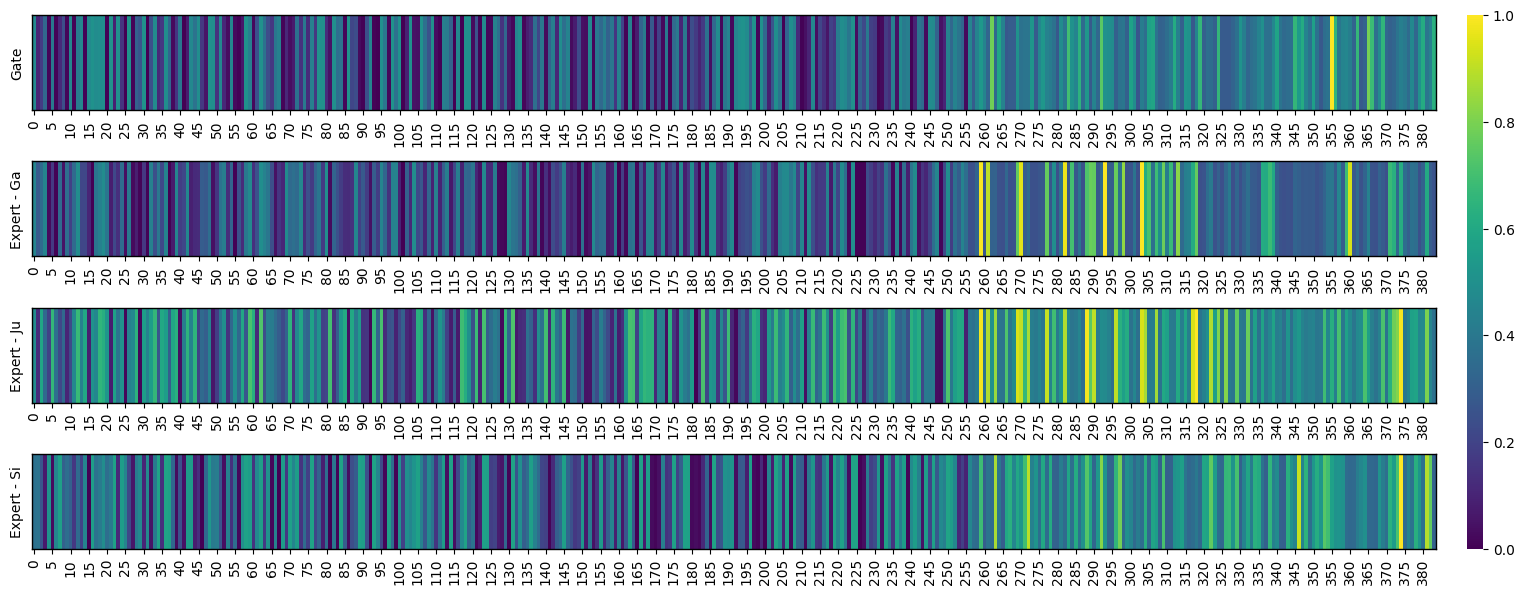

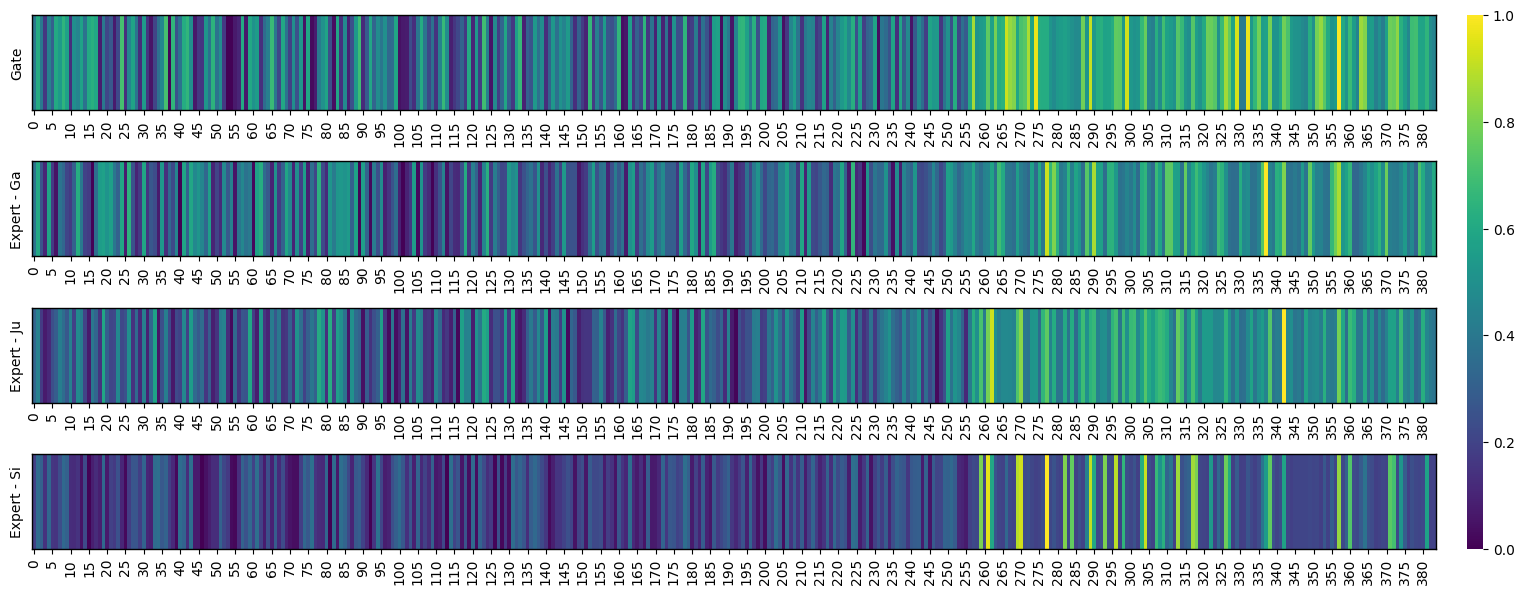

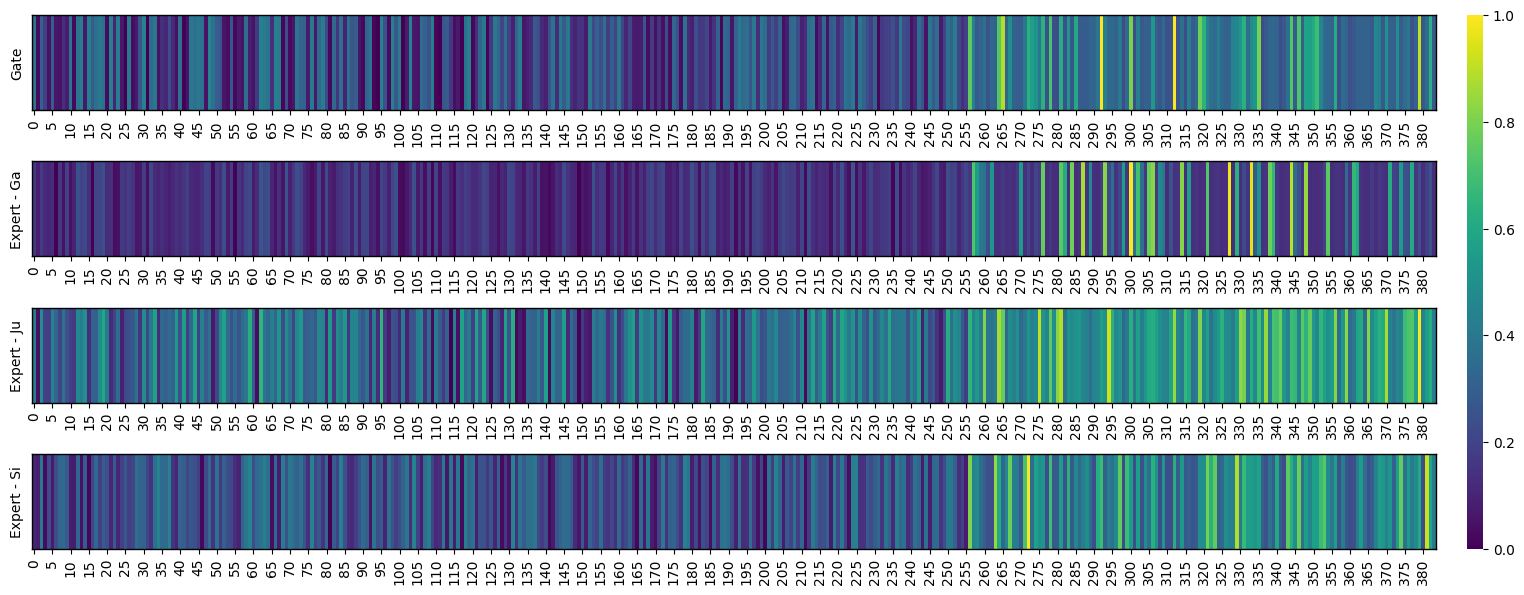

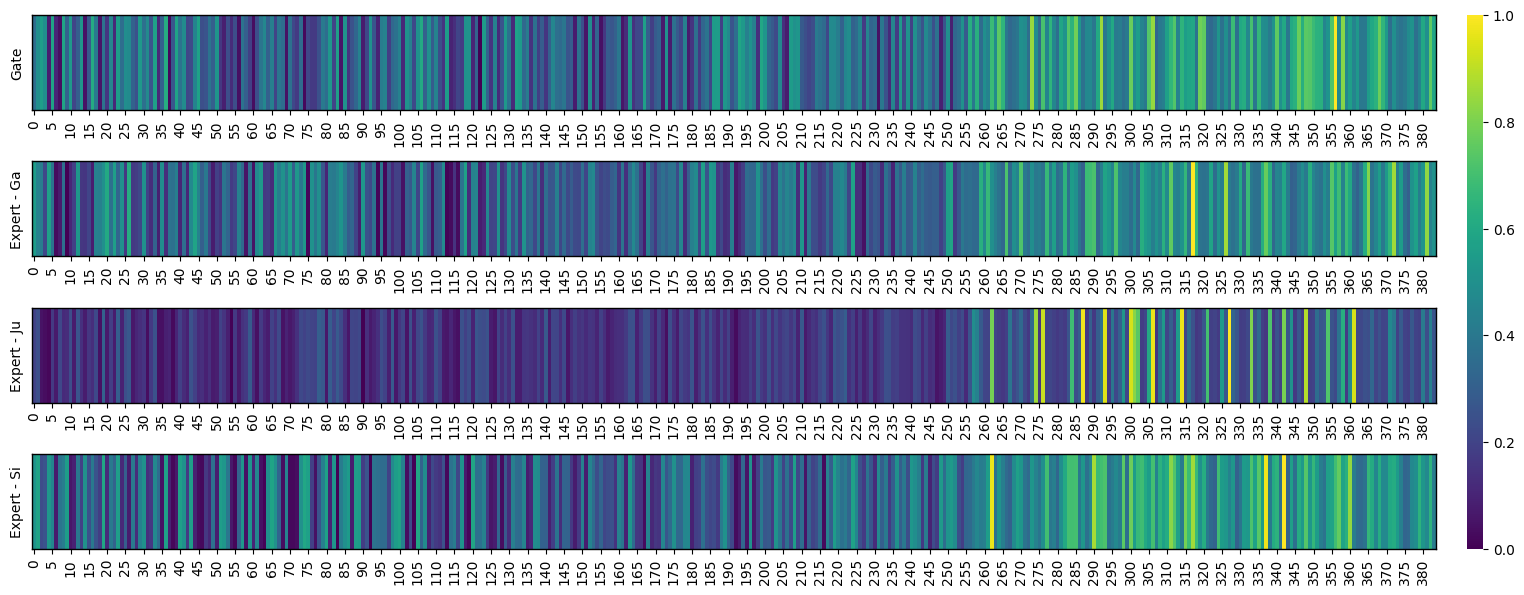

In [7]:
for study_cls, output_map_i in output_map.items():
    if not output_map_i:
        continue

    print_h(study_cls)
    plot_output_heatmap(output_map_i, name=study_cls, save_dir=out_viz_dir,  plot=False)
    print()